In [1]:
import numpy as np
from glob import glob
import cv2
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as lay
import os
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [2]:
with open('vacob.pickle', 'rb') as handle:
    vacob = pickle.load(handle)

In [3]:
max=40
from tensorflow.keras.applications import ResNet50
incept_model = ResNet50(include_top=True)
last = incept_model.layers[-2].output
resnet = Model(inputs = incept_model.input,outputs = last)
resnet.trainable=False
resnet.summary()
image_model = Sequential()
image_model.add(lay.Dense(128, input_shape=(2048,), activation='relu'))
image_model.add(lay.RepeatVector(max))
language_model = Sequential()
language_model.add(lay.Embedding(input_dim=len(vacob)+1, output_dim=128, input_length=max))
language_model.add(lay.LSTM(256, return_sequences=True))
language_model.add(lay.TimeDistributed(lay.Dense(128)))
conca = lay.Concatenate()([image_model.output, language_model.output])
x = lay.LSTM(128, return_sequences=True)(conca)
x = lay.LSTM(512, return_sequences=False)(x)
out = lay.Dense(len(vacob)+1,activation='softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [4]:
model.load_weights('best_model_acc.h5')

In [5]:
inv_vacob = {v:k for k, v in vacob.items()}

 a boy flies out of the water


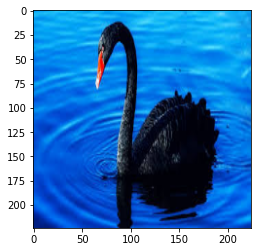

In [6]:
h=7000
test=cv2.imread('img/duck.jpg')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.resize(test, (224,224))
test = test.reshape(1,224,224,3)
predt = resnet.predict(test).reshape(1,2048)

word=['<sos>']
word_encoded=[]
stement=''
for i in range(20):
    word_encoded=[]
    for w in word:
        word_encoded.append(vacob[w])


    encoded = [word_encoded]
    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max)

    prediction = np.argmax(model.predict([predt, encoded]))

    sampled_word = inv_vacob[prediction]
    if sampled_word == '<eos>':
        break

    word.append(sampled_word)
    stement+=' '+sampled_word

plt.imshow(test.reshape(224,224,3))
print(stement)